In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer
from manapy.cuda.utils import (VarClass, GPU_Backend)
###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  GPU_Backend.float_precision = 'float32'
  running_conf = Struct(backend="numba", signature=True, cache=True, float_precision="single")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P, running_conf)

In [2]:
from manapy.solvers.advec import AdvectionSolver

dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
domain, ne, u, v, w, P, conf = init(dim=dim, mesh_path=mesh_file)

S = AdvectionSolver(ne, vel=(u, v), conf=conf)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...


In [4]:
# args list
#? The order is imported of the argument list

S.var.convective[:] = 0.5

VarClass.convert_to_var_class([
    domain.nodes,
    domain.faces,
    domain.cells,
    domain.halos,
    domain,
    ne,
    S,
    u,
    v,
    S.w,
    ne.domain._cells,

])

args = [
  S.var.cell,
  S.var.convective,
  S.var.dissipative,
  S.var.source,
  0.1,
  S.domain.cells.volume ,
]

for arg in args:
  print(type(arg))

---------------------------------
---------------------------------
can't get attr _nbnodes => _nbnodes
can't get attr nbnodes => _nbnodes
can't set attr for R_x => can't set attribute
can't set attr for R_y => can't set attribute
can't set attr for R_z => can't set attribute
set att: _R_x
set att: _R_y
set att: _R_z
set att: _cellid
set att: _ghostcenter
set att: _ghostfaceinfo
set att: _ghostid
set att: _haloghostcenter
set att: _haloghostfaceinfo
set att: _haloghostid
set att: _halonid
set att: _lambda_x
set att: _lambda_y
set att: _lambda_z
set att: _loctoglob
set att: _name
set att: _number
set att: _oldname
set att: _periodicid
set att: _vertex
can't set attr for cellid => can't set attribute
can't set attr for ghostcenter => can't set attribute
can't set attr for ghostfaceinfo => can't set attribute
can't set attr for ghostid => can't set attribute
can't set attr for haloghostcenter => can't set attribute
can't set attr for haloghostfaceinfo => can't set attribute
can't set attr

In [5]:
from manapy.solvers.advec.fvm_utils import update_new_value as cpu_function
from manapy.cuda.manapy.solvers.advec.cuda_fvm_utils import get_kernel_update_new_value as gpu_function

numba_fun = domain.backend.compile(cpu_function, echo=True, signature=True)
cuda_fun = gpu_function()

compile update_new_value to cpu => signature=(float32[:], float32[:], float32[:], float32[:], float32, float32[:])
compile kernel_update_new_value to cuda => signature=void(float32[:], float32[:], float32[:], float32[:], float32, float32[:])


In [6]:
numba_fun(*args)
%timeit numba_fun(*args)

171 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
cuda_fun(*args)
%timeit cuda_fun(*args)

CUDADispatcher(<function get_kernel_update_new_value.<locals>.kernel_update_new_value at 0x79ffb7f40700>) is called
VarClass<float32, (105826,)>
VarClass<float32, (105826,)>
VarClass<float32, (105826,)>
VarClass<float32, (105826,)>
<class 'float'>
VarClass<float32, (105826,)>


/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


205 µs ± 5.94 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
# verify
from manapy.cuda.manapy.util_kernels.get_kernel_assign import get_kernel_assign

cuda_assign = get_kernel_assign()

def plot(a):
  b = VarClass.to_device(a).copy_to_host()
  plt.plot(a, label="cpu")
  plt.plot(b, label="gpu")
  plt.legend()
  plt.show()

def verify(a, decimal):
  b = VarClass.to_device(a)
  np.testing.assert_almost_equal(a, b, decimal=decimal)

args[0][:] = 1
cuda_assign(args[0], 1)
numba_fun(*args)
cuda_fun(*args)

for i, arg in enumerate(args):
  print(f"{i + 1} => test arg {arg}")
  verify(arg, decimal=2)
  
#host_ne_c

compile kernel_assign to cuda => signature=void(float32[:], float32)
CUDADispatcher(<function kernel_assign at 0x79ffb7f404c0>) is called
VarClass<float32, (105826,)>
<class 'int'>
1 => test arg [3882.4414 3622.5625 3931.3777 ... 7312.883  8758.625  8671.885 ]
2 => test arg [0.5 0.5 0.5 ... 0.5 0.5 0.5]
3 => test arg [0. 0. 0. ... 0. 0. 0.]
4 => test arg [0. 0. 0. ... 0. 0. 0.]
5 => test arg 0.1
6 => test arg [1.2881813e-05 1.3806196e-05 1.2721423e-05 ... 6.8381842e-06 5.7093107e-06
 5.7664242e-06]


/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


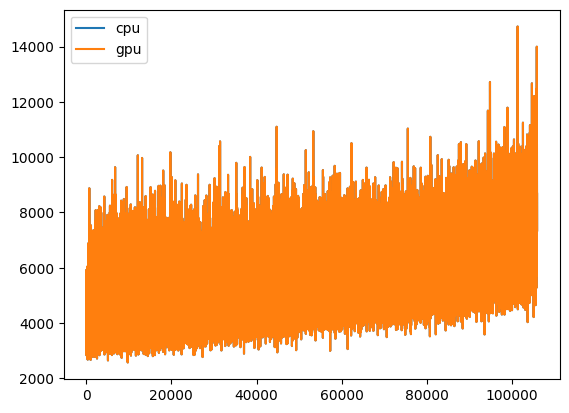

In [14]:
plot(args[0])